### **Library Imports**

In [1]:
import os
import re
import torch
import random as r
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from time import time
from torch import nn, optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader as DL
from torchvision import models, transforms

from sklearn.model_selection import KFold

### **Utilities and Constants**

In [2]:
SEED = 42


def breaker(num: int=50, char: str="*") -> None:
    print("\n" + num*char + "\n")


def show_graphs(L: list) -> None:
    TL, VL = [], []
    for i in range(len(L)):
        TL.append(L[i]["train"])
        VL.append(L[i]["valid"])
    x_Axis = np.arange(1, len(TL) + 1)
    plt.figure(figsize=(8, 6))
    plt.plot(x_Axis, TL, "r", label="Train")
    plt.plot(x_Axis, VL, "b", label="Valid")
    plt.legend()
    plt.grid()
    plt.title("Loss Graph")
    plt.show()


def show(image: np.ndarray, cmap: str="gnuplot2") -> None:
    plt.figure()
    plt.imshow(image, cmap=cmap)
    plt.axis("off")
    plt.show()

### **Configuration**

In [3]:
class CFG(object):
    def __init__(self, 
                 seed: int = 42,
                 in_channels: int = 3,
                 size: int = 224,
                 n_splits: int = 5,
                 batch_size: int = 16,
                 epochs: int = 25,
                 early_stopping: int = 5,
                 lr: float = 1e-4,
                 wd: float = 0.0,
                 max_lr: float = 1e-3,
                 pct_start: float = 0.2,
                 steps_per_epoch: int = 100,
                 div_factor: int = 1e3, 
                 final_div_factor: float = 1e3,
                 ):
        
        self.seed = seed
        self.in_channels = in_channels
        self.size = size
        self.n_splits = n_splits
        self.batch_size = batch_size
        self.epochs = epochs
        self.early_stopping = early_stopping
        self.lr = lr
        self.wd = wd
        self.max_lr = max_lr
        self.pct_start = pct_start
        self.steps_per_epoch = steps_per_epoch
        self.div_factor = div_factor
        self.final_div_factor = final_div_factor
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize([0.46986, 0.45942, 0.45442],
                                                     [0.29034, 0.28930, 0.29758]),
                                ])
        self.save_path = "saves"
        if not os.path.exists(self.save_path): os.makedirs(self.save_path)
    
cfg = CFG(seed=SEED, size=224)

### **Dataset Template**

In [4]:
class DS(Dataset):
    def __init__(self, images: np.ndarray, transform=None):
        self.images = images
        self.transform = transform
    
    def __len__(self):
        return self.images.shape[0]
    
    def __getitem__(self, idx):
        return self.transform(self.images[idx])

### **Model**

In [5]:
class Model(nn.Module):
    def __init__(self, in_channels: int = 3):
        super(Model, self).__init__()

        self.encoder = models.resnet50(pretrained=True, progress=True)
        # self.freeze()
        self.encoder = nn.Sequential(*[*self.encoder.children()][:-2])
        if in_channels != 3:
            self.encoder[0] = nn.Conv2d(in_channels=in_channels, 
                                        out_channels=self.encoder[0].out_channels, 
                                        kernel_size=self.encoder[0].kernel_size, 
                                        stride=self.encoder[0].stride,
                                        padding=self.encoder[0].padding)

        self.decoder = nn.Sequential()
        self.decoder.add_module("DC1", nn.ConvTranspose2d(in_channels=2048, out_channels=512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)))
        self.decoder.add_module("AN1", nn.ReLU())
        self.decoder.add_module("UP1", nn.Upsample(scale_factor=2))
        self.decoder.add_module("DC2", nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)))
        self.decoder.add_module("AN2", nn.ReLU())
        self.decoder.add_module("UP2", nn.Upsample(scale_factor=2))
        self.decoder.add_module("DC3", nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)))
        self.decoder.add_module("AN3", nn.ReLU())
        self.decoder.add_module("UP3", nn.Upsample(scale_factor=2))
        self.decoder.add_module("DC4", nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)))
        self.decoder.add_module("AN4", nn.ReLU())
        self.decoder.add_module("UP4", nn.Upsample(scale_factor=2))
        self.decoder.add_module("DC5", nn.ConvTranspose2d(in_channels=64, out_channels=in_channels, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)))
        self.decoder.add_module("AN5", nn.ReLU())
        self.decoder.add_module("UP5", nn.Upsample(scale_factor=2))
    
    def freeze(self):
        for params in self.parameters(): params.requires_grad = False
    
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        
        return encoded, decoded

### **Fit and Predict Helper**

In [6]:
def fit(model=None, 
        optimizer=None, 
        scheduler=None, 
        epochs=None, 
        early_stopping_patience=None, 
        dataloaders=None, 
        fold=None, 
        device=None,
        save_path=None,
        verbose=False) -> tuple:
    
    if verbose:
        breaker()
        if fold: print(f"Training Fold {fold}...")
        else: print("Training ...")
        breaker()
        
    bestLoss = {"train" : np.inf, "valid" : np.inf}
    Losses, LRs = [], []
    if fold: name = f"state_fold_{fold}.pt"
    else: name = "state.pt"

    start_time = time()
    for e in range(epochs):
        e_st = time()
        epochLoss = {"train" : 0.0, "valid" : 0.0}

        for phase in ["train", "valid"]:
            if phase == "train":
                model.train()
            else:
                model.eval()
            
            lossPerPass = []

            for X in dataloaders[phase]:
                X = X.to(device)

                optimizer.zero_grad()
                with torch.set_grad_enabled(phase == "train"):
                    _, decoded = model(X)
                    loss = torch.nn.MSELoss()(decoded, X)
                    if phase == "train":
                        loss.backward()
                        optimizer.step()
                        if scheduler: scheduler.step()
                lossPerPass.append(loss.item())
            epochLoss[phase] = np.mean(np.array(lossPerPass))
        LRs.append(scheduler.get_last_lr())
        Losses.append(epochLoss)
        
        if early_stopping_patience:
            if epochLoss["valid"] < bestLoss["valid"]:
                bestLoss = epochLoss
                BLE = e + 1
                torch.save({"model_state_dict"     : model.state_dict(),
                            "optim_state_dict"     : optimizer.state_dict(),
                            "scheduler_state_dict" : scheduler.state_dict()},
                           os.path.join(save_path, name))
                early_stopping_step = 0
            else:
                early_stopping_step += 1
                if early_stopping_step > early_stopping_patience:
                    print("\nEarly Stopping at Epoch {}".format(e + 1))
                    break
        
        if epochLoss["valid"] < bestLoss["valid"]:
            bestLoss = epochLoss
            BLE = e + 1
            torch.save({"model_state_dict"     : model.state_dict(),
                        "optim_state_dict"     : optimizer.state_dict(),
                        "scheduler_state_dict" : scheduler.state_dict()},
                        os.path.join(save_path, name))
        
        if verbose:
            print("Epoch: {} | Train Loss: {:.5f} | Valid Loss: {:.5f} | Time: {:.2f} seconds".format(e+1, epochLoss["train"], epochLoss["valid"], time()-e_st))

    if verbose:                                           
        breaker()
        print(f"Best Validation Loss at Epoch {BLE}")
        breaker()
        print("Time Taken [{} Epochs] : {:.2f} minutes".format(len(Losses), (time()-start_time)/60))
    
    return Losses, LRs, BLE, name


def predict_batch(model=None, dataloader=None, device=None, in_channels=None, size=None, path=None) -> np.ndarray:
    model.load_state_dict(torch.load(path, map_location=device)["model_state_dict"])
    model.to(device)    
    model.eval()
    
    y_pred = torch.zeros(1, in_channels, size, size).to(device)
    
    for X in dataloader:
        X = X.to(device)
        with torch.no_grad():
            output = torch.sigmoid(model(X))
        y_pred = torch.cat((y_pred, output), dim=0)
    
    return y_pred[1:].detach().cpu().numpy()


def predict(model=None, device=None, image=None, size=None, path=None) -> np.ndarray:
    model.load_state_dict(torch.load(path, map_location=device)["model_state_dict"])
    model.to(device)    
    model.eval()
    
    h, w, _ = image.shape
    temp_image = cv2.resize(src=image, dsize=(size, size), interpolation=cv2.INTER_AREA)

    with torch.no_grad(): _, decoded = model(transforms.ToTensor()(temp_image).unsqueeze(dim=0).to(cfg.device))
        
    decoded_image = np.clip(decoded.squeeze().detach().cpu().numpy().transpose(1, 2, 0)*255, 0, 255).astype("uint8")
    return cv2.resize(src=decoded_image, dsize=(w, h), interpolation=cv2.INTER_AREA)

### **Train**

In [7]:
images = np.load(f"../input/scd-images-{cfg.size}/images_{cfg.size}.npy")

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]


**************************************************

Training ...

**************************************************

Epoch: 1 | Train Loss: 0.77612 | Valid Loss: 0.62424 | Time: 109.86 seconds
Epoch: 2 | Train Loss: 0.59120 | Valid Loss: 0.55933 | Time: 104.49 seconds
Epoch: 3 | Train Loss: 0.54896 | Valid Loss: 0.53402 | Time: 104.43 seconds
Epoch: 4 | Train Loss: 0.53058 | Valid Loss: 0.51984 | Time: 104.38 seconds
Epoch: 5 | Train Loss: 0.53188 | Valid Loss: 0.51833 | Time: 104.73 seconds
Epoch: 6 | Train Loss: 0.51721 | Valid Loss: 0.51094 | Time: 104.44 seconds
Epoch: 7 | Train Loss: 0.51623 | Valid Loss: 0.52463 | Time: 103.20 seconds
Epoch: 8 | Train Loss: 0.52487 | Valid Loss: 0.51544 | Time: 103.28 seconds
Epoch: 9 | Train Loss: 0.53026 | Valid Loss: 0.51099 | Time: 103.29 seconds
Epoch: 10 | Train Loss: 0.51358 | Valid Loss: 0.50719 | Time: 104.64 seconds
Epoch: 11 | Train Loss: 0.50701 | Valid Loss: 0.50478 | Time: 104.68 seconds
Epoch: 12 | Train Loss: 0.50423 | Valid Los

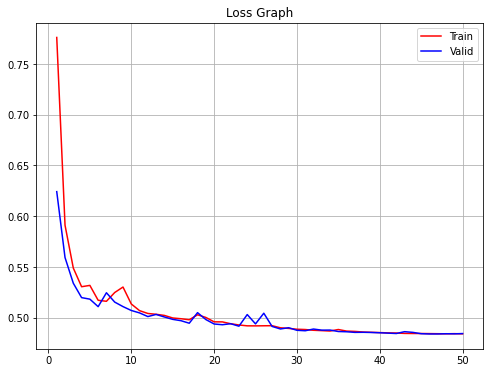


**************************************************



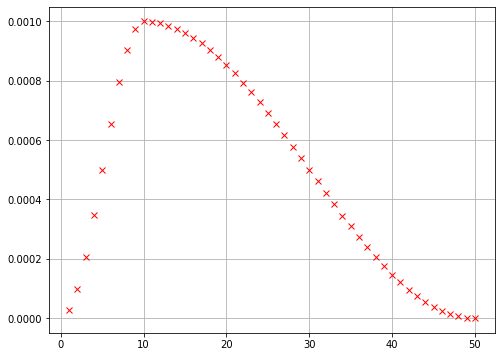


**************************************************



In [8]:
for tr_idx, va_idx in KFold(n_splits=cfg.n_splits, shuffle=True, random_state=cfg.seed).split(images):
    break

tr_images, va_images = images[tr_idx], images[va_idx]

tr_data_setup = DS(tr_images, cfg.transform)
va_data_setup = DS(va_images, cfg.transform)

dataloaders = {
    "train" : DL(tr_data_setup, batch_size=cfg.batch_size, shuffle=True, generator=torch.manual_seed(cfg.seed)),
    "valid" : DL(va_data_setup, batch_size=cfg.batch_size, shuffle=False)
}

cfg = CFG(seed=SEED, size=224, epochs=50, early_stopping=5, lr=1e-3, wd=0.0, steps_per_epoch=len(dataloaders["train"]))

torch.manual_seed(cfg.seed)
model = Model().to(cfg.device)
optimizer = optim.Adam([p for p in model.parameters() if p.requires_grad], lr=cfg.lr, weight_decay=cfg.wd)
scheduler = optim.lr_scheduler.OneCycleLR(optimizer=optimizer, 
                                          max_lr=cfg.max_lr, 
                                          epochs=cfg.epochs, 
                                          steps_per_epoch=cfg.steps_per_epoch,
                                          pct_start=cfg.pct_start, 
                                          div_factor=cfg.div_factor, 
                                          final_div_factor=cfg.final_div_factor)

L, LRs, BLE, name = fit(model=model, 
                        optimizer=optimizer, 
                        scheduler=scheduler, 
                        epochs=cfg.epochs, 
                        early_stopping_patience=cfg.early_stopping, 
                        dataloaders=dataloaders, 
                        device=cfg.device,
                        save_path=cfg.save_path,
                        verbose=True)

breaker()
show_graphs(L)
breaker()
x_Axis = [i+1 for i in range(len(LRs))]
plt.figure(figsize=(8, 6))
plt.plot(x_Axis, LRs, "rx")
plt.grid()
plt.show()
breaker()